# ЛР №7

Основные понятия ООП. Наследование. Полиморфизм.

# Основное задание




Написать базовый класс BaseProcessing, который предоствляет интерфейс для обработки данных (сигналы и изображения).

В классе BaseProcessing реализовать следующие абстрактные методы:

**Интерфейс BaseProcessing**

* `_filtering()` — осуществляет фильтрацию (абстрактный метод).
* `visualize()` — визуализирует сигнал/изображение (абстрактный метод).
* `get_shape()` — возвращает размерность (абстрактный метод).
* `feature_extraction()` — возвращает вектор признаков (абстрактный метод).


Класс SignalProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс SignalProcessing** (код для реализации отдельных методов ниже)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(signal)` — осуществляет фильтрацию сигнала (возвращает отфильтрованный сигнал).
* `visualize()` — визуализирует сигнал.
* `get_shape()` — возвращает длину сигнала.
* `_signal_find_peaks(signal, find_peaks_parametres)` — находит точки максимума сигнала и возвращает их в виде списка.
* `_calculate_RR_intervals()` — производит расчет длительности RR интервалов (попарных расстояний между пиками) и возвращает длины RR интервалов в виде списка.
В этом методе вызываются методы _filtering и _signal_find_peak.
* `feature_extraction()` — возвращает статистические характеристики RR интервалов на записи ECG - среднее, std, min, max (в виде списка - вектор признаков). В этом методе вызывается метод _calculate_RR_intervals.

Класс ImageProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс ImageProcessing** (код для реализации отдельных методов из предыдущей лабораторной)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(image)` — применяет фильтр Гаусса к изображению (возвращает отфильтрованное изображение).
* `visualize()` — визуализирует изображение.
* `get_shape()` — возвращает размерность изображения.
* `_create_gabor_filter(parameters)` — создает и возвращает фильтр Габора с заданными параметрами.
* `feature_extraction()` — применяет _filtering() к изображению, считает признаки с _create_gabor_filter(parameters)и возвращает вектор признаков: среднее и дисперсию по изображению.

*можно добавить свои методы


Изображение и синал находятся в папке

In [1]:
#Необходимые модули и функции
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import heartpy as hp
from scipy.signal import find_peaks
from abc import ABC, abstractmethod

In [2]:
class BaseProcessing(ABC):

    @abstractmethod
    def _filtering(self):
      pass

    @abstractmethod
    def visualize(self):
      pass

    @abstractmethod
    def get_shape(self):
      pass

    @abstractmethod
    def feature_extraction(self):
      pass

In [3]:
class SignalProcessing(BaseProcessing):

    def __init__(self, path):
        self.path = path
        self.signal = self.load_signal()

    def load_signal(self):
        data = pd.read_csv(self.path)
        signal = data['MLII']
        return signal

    def visualize(self):
        plt.plot(self.signal)
        plt.show()

    def get_shape(self):
        return len(self.signal)

    def _filtering(self):
        filtered = hp.filter_signal(self.signal, cutoff = [0.75, 3.5], sample_rate = 100, order = 3, filtertype='bandpass')
        return filtered

    def _signal_find_peaks(self, signal, find_peaks_parametres):
        peaks, _ = find_peaks(signal, height=find_peaks_parametres)
        return peaks

    def _calculate_RR_intervals(self):
        RR = []
        height = 20
        peaks = self._signal_find_peaks(self._filtering(), height)
        for i in range(len(peaks)-1):
            RR.append(peaks[i+1]-peaks[i])
        return RR

    def feature_extraction(self):
        data = self._calculate_RR_intervals()
        features = []
        features.append(np.mean(data))
        features.append(np.std(data))
        features.append(max(data))
        features.append(min(data))
        return features

In [4]:
class ImageProcessing(BaseProcessing):
    
    def __init__(self, path):
        self.path = path
        self.image = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE)

    def _filtering(self):
        return ndi.gaussian_filter(self.image, 0.5)

    def visualize(self):
        plt.imshow(self.image, cmap='gray')
        plt.show()

    def get_shape(self):
        return self.image.shape

    def _create_gabor_filter(self, frequency=0.25, theta=np.pi, sigma=1):
        return np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))

    def feature_extraction(self):
        conv = ndi.convolve(self._filtering(), self._create_gabor_filter(), mode = 'wrap')
        return [conv.mean(), conv.var()]

    def plot_filtration(self):
        filtered_image = self._filtering()
        plt.imshow(filtered_image, cmap = 'gray')
        plt.show()

    def gabor_plot(self):
        conv = ndi.convolve(self._filtering(), self._create_gabor_filter(), mode = 'wrap')
        plt.imshow(conv, cmap='gray')
        plt.show()

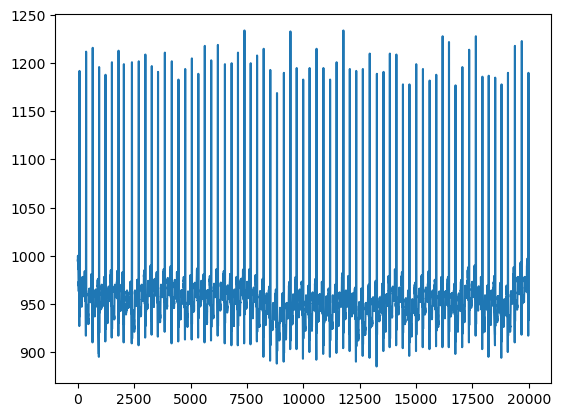

[293, 293, 284, 284, 284, 294, 236, 358, 303, 292, 285, 277, 303, 308, 295, 299, 295, 287, 287, 284, 296, 313, 297, 282, 285, 279, 283, 293, 293, 298, 304, 290, 279, 288, 284, 309, 303, 298, 288, 301, 285, 284, 295, 305, 317, 295, 280, 289, 292, 288, 300, 299, 297, 293, 283, 282, 290, 303, 300, 299, 290, 280, 287, 282, 285, 307, 305, 233, 66]


[288.6231884057971, 31.077323597890175, 358, 66]

In [5]:
path = 'ecg.csv'
signal = SignalProcessing(path)
signal.visualize()
RR = signal._calculate_RR_intervals()
print(RR)
signal.feature_extraction()

In [6]:
signal.get_shape()

20000

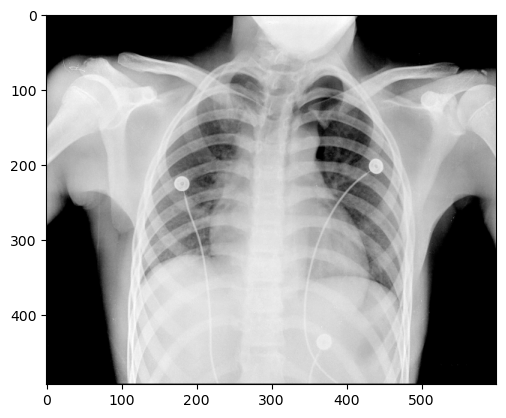

In [7]:
path = "chest-xray.tif"
image = ImageProcessing(path)

image.visualize()

In [8]:
image.get_shape()

(493, 600)

In [9]:
image.feature_extraction()

[41.113566599053414, 670.1179849805205]

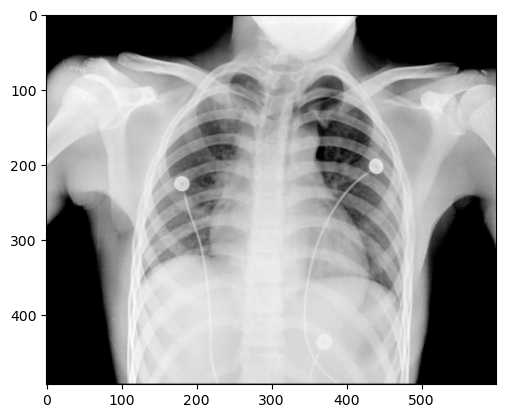

In [10]:
image.plot_filtration()

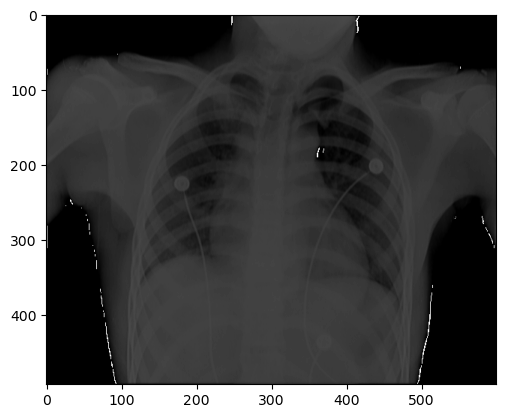

In [11]:
image.gabor_plot()

### Для сигнала

In [ ]:
#загрузка сигнала из .csv файла с pandas
df = pd.read_csv('path_to_ecg/ecg.csv')
plt.plot(df['MLII'])
plt.show()

In [ ]:
#размерность
df['MLII'].shape

In [ ]:
#фильтрация сигнала с библиотекой heartpy
filtered = hp.filter_signal(df['MLII'], cutoff = [0.75, 3.5], sample_rate = 100, order = 3, filtertype='bandpass')
plt.plot(filtered)
plt.show()

In [ ]:
#поиск точек максимума с библиотекой scipy
peaks, _ = find_peaks(filtered, height=20)
plt.plot(filtered)
plt.plot(peaks, filtered[peaks], "ecg")
plt.show()

### Для изображения

In [ ]:
#Создание фильтра Габора
frequency = 0.25
theta = np.pi
sigma = 1
kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
plt.imshow(kernel)
plt.show()

In [ ]:
#Чтение изображения
image = cv2.imread('path_to_image', cv2.IMREAD_GRAYSCALE)
#Применение филтра Гаусса к изображению
image_filtered = ndi.gaussian_filter(image, .5)

In [ ]:
#Размерность изображения
image.shape

In [ ]:
#свертка изображения с фильтром Габора
conv = ndi.convolve(image_filtered, kernel, mode='wrap')
plt.imshow(conv)
plt.show()

In [ ]:
#Расчет вертора признаков изображения
feats = [conv.mean(), conv.var()]